In [17]:
import os, sys, re, datetime, shutil
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.table import Table
from collections import OrderedDict
#LTE_calc_path = os.path.expanduser('~/Cloud/GitLab/COExcitation/tmp/calc_LTE_R_CI10CO21')
cache_table_path = os.getcwd()

In [18]:
# User-defined global parameters

#list_of_X_CICO = np.arange(0.05, 3.00+0.05, 0.05)
#list_of_N_CO = 10**np.arange(17.0, 20.0, 0.25)
list_of_T_kin = np.logspace(np.log10(10.0), np.log10(150.0), num=50, endpoint=True)
list_of_d_V = np.logspace(np.log10(1.0), np.log10(90.0), num=50, endpoint=True)

list_of_d_V_limit_per_panel = [3., 10., 25., 50., 40., 70., 90.] # d_V in km/s
list_of_CO_abundance_per_panel = [1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4, 1e-4]
list_of_highlight_text_label_per_panel = ['Galactic \nclouds', # Solomon+87,Heyer13
                                          'NGC3627 \nSF disk', 
                                          'NGC3627 \nSF bar-ends',
                                          'NGC1808/7469 \nSB disk',
                                          'NGC4321 \nLINER nuc',
                                          'NGC3627 \nAGN nuc',
                                          'NGC7469 \nAGN nuc']
list_of_highlight_Flux_Kkms_CO10_range_per_panel = [
    (30.,50.), (100.,200.), (350.,500.), (800.,1000.), 
    (700.,1000.), (1000.,1400.), (2000.,2200.) ] # K km s-1
list_of_highlight_Sigma_H2_range_per_panel = [None]*len(list_of_highlight_text_label_per_panel)
list_of_highlight_R_CI10CO21_per_panel = [0.1, 0.1, 0.1, 0.2, 0.06, 0.1, 0.5]
#list_of_highlight_line_color_per_panel = ['magenta', 'blue', 'green', 'green', 'lime', 'orange', 'red']

func_alphaCO_T_only = lambda t, abu: \
                    ( (0.18 + (t/75.)**2.13) * (t/75.)**(-1.51) - 0.42 ) * \
                    (1e-4) / abu # 20220310, see 'calc_LTE_alpha_CO_CI_new.ipynb', no Helium
func_alphaCO_T_NLCorr = lambda t, abu: \
                    ( (0.18 + (t/75.)**2.13) * (t/75.)**(-1.51) - 0.42 ) * \
                    (1e-4) / abu # 20220310, see 'calc_LTE_alpha_CO_CI_new.ipynb', no Helium


list_of_alphaCO_for_T_kin = np.array([func_alphaCO(t, abu) for t, abu in \
                                                list(zip(list_of_T_kin, list_of_CO_abundance_for_T_kin))])

# Note that if 'list_of_highlight_Flux_Kkms_CO10_range_per_panel' or 'func_alphaCO' is changed, 
# set 'use_cache_file' to False!
use_cache_file = False # True # False

#func_alphaCO = lambda t, abu: \
#                   np.max([0.3*(t/100.)**(-1.1) * (3e-4) / abu, 
#                           0.5]) # see 'calc_LTE_alpha_CO_CI.ipynb'
#func_alphaCO = lambda t, abu: \
#                    0.15 * (1 + (t/75.)**2.4) * (t/75.)**(-1.2) * \
#                    (3e-4) / abu # 20220112, see 'calc_LTE_alpha_CO_CI.ipynb', no Helium

out_fig_size = [14.5, 8.]

out_fig_margin = dict(left=0.065, right=0.96, bottom=0.08, top=0.92)


In [19]:
CO = {}
CO['Einstein_A'] = np.array([
    7.203e-08, 6.910e-07, 2.497e-06, 6.126e-06, 1.221e-05, 2.137e-05, 3.422e-05, 5.134e-05, 7.330e-05, 1.006e-04, 
    1.339e-04, 1.735e-04, 2.200e-04, 2.739e-04, 3.354e-04, 4.050e-04, 4.829e-04, 5.695e-04, 6.650e-04, 7.695e-04, 
    8.833e-04, 1.006e-03, 1.139e-03, 1.281e-03, 1.432e-03, 1.592e-03, 1.761e-03, 1.940e-03, 2.126e-03, 2.321e-03, 
    2.524e-03, 2.735e-03, 2.952e-03, 3.175e-03, 3.404e-03, 3.638e-03, 3.878e-03, 4.120e-03, 4.365e-03, 4.613e-03, 
])
CO['E_u'] = np.array([
    5.53,      16.60,   33.19,   55.32,   82.97,  116.16,  154.87,  199.11,  248.88, 304.16, 
    364.97,   431.29,  503.13,  580.49,  663.35,  751.72,  845.59,  944.97, 1049.84, 1160.20, 
    1276.05, 1397.38, 1524.19, 1656.47, 1794.23, 1937.44, 2086.12, 2240.24, 2399.82, 2564.83, 
    2735.28, 2911.15, 3092.45, 3279.15, 3471.27, 3668.78, 3871.69, 4079.98, 4293.64, 4512.67, 
])
CO['nu'] = np.array([
     115.2712018,  230.5380000,  345.7959899,  461.0407682,  576.2679305, 
     691.4730763,  806.6518060,  921.7997000, 1036.9123930, 1151.9854520, 
    1267.0144860, 1381.9951050, 1496.9229090, 1611.7935180, 1726.6025057, 
    1841.3455060, 1956.0181390, 2070.6159930, 2185.1346800, 2299.5698420, 
    2413.9171130, 2528.1720600, 2642.3303459, 2756.3875840, 2870.3394070, 
    2984.1814550, 3097.9093610, 3211.5187506, 3325.0052827, 3438.3646110, 
    3551.5923610, 3664.6841800, 3777.6357280, 3890.4427170, 4003.1007876, 
    4115.6055850, 4227.9527744, 4340.1381120, 4452.1571221, 4564.0056399, 
])

In [20]:
CI = {}
CI['Einstein_A'] = np.array([
    7.880E-08, 2.650E-07, 
    #1.810E-14, 
])
CI['E_u'] = np.array([
    23.620, 62.462, 
    # 62.462, 
])
CI['nu'] = np.array([
    492.160651, 809.34197, 
    # 1301.50262, 
])

In [21]:
def calc_Q(E_u, T_kin, N=None):
    E_j = np.concatenate([[0.0], E_u])
    if N is None:
        N = len(E_j)
    j = np.arange(N)
    E_j = E_j[0:N]
    #E_j = (j*(j+1)) * E_u[0]
    return np.sum(1.0 * (j+(j+1)) * np.exp(-1.0 * E_j / T_kin))

In [22]:
def calc_Bnu(
        nu, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    Bnu = 2*h*(nu*1e9)**3/c**2 * (1.0 / (np.exp(hnu_kt) - 1.0))
    return Bnu

def calc_Bnu_CI10(T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_Bnu(
        nu = CI['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_Bnu_CO21(T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_Bnu(
        nu = CO['nu'][idx_trans], 
        T_ex = T_ex, 
    )

def calc_tau(
        nu, 
        g_u, 
        Q, 
        A_ul, 
        N_dV, 
        T_ex, 
    ):
    c = const.c.cgs.value # 2.99792458e+10 cm / s
    pi = np.pi
    h = const.h.cgs.value # 6.62607015e-27 erg s
    k = const.k_B.cgs.value # 1.380649e-16 erg / K
    hnu_kt = h*(nu*1e9)/(k*T_ex)
    #print('nu', nu)
    #print('Q', Q)
    #print('c**3/(8.0*pi*(nu*1e9)**3)', c**3/(8.0*pi*(nu*1e9)**3))
    #print('hnu_kt', hnu_kt)
    N_dV_cm_2_km_s_1 = N_dV # input should have a unit of cm^{-2} (km s^{-1})^{-1}
    N_dV_cm_2_cm_s_1 = N_dV_cm_2_km_s_1 / 1e5 # km^{-1} to cm^{-1}
    return c**3/(8.0*pi*(nu*1e9)**3) * (g_u/Q) * A_ul * N_dV_cm_2_cm_s_1 / 1.0645 * (1.0 - np.exp( -hnu_kt ))

def calc_tau_CI10(N_dV, T_ex):
    global CI
    j_u = 1
    j_l = 0
    idx_trans = 0
    return calc_tau(
        nu = CI['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CI['E_u'], T_ex), 
        A_ul = CI['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )

def calc_tau_CO21(N_dV, T_ex):
    global CO
    j_u = 2
    j_l = 1
    idx_trans = 1
    return calc_tau(
        nu = CO['nu'][idx_trans], 
        g_u = 2*j_u+1, 
        Q = calc_Q(CO['E_u'], T_ex), 
        A_ul = CO['Einstein_A'][idx_trans],
        N_dV = N_dV, 
        T_ex = T_ex, 
    )


In [23]:
def calc_one_LTE_R_CI10CO21(
        N_CO, 
        d_V, 
        T_kin, 
        X_CICO, 
        T_CMB = 2.73, 
        verbose = True,
        overwrite = False, 
    ):
    #
    global CO
    global CI
    #
    nu_CI10 = CI['nu'][0]
    nu_CO21 = CO['nu'][1]

    tau_CI10 = calc_tau_CI10(N_dV = X_CICO*N_CO/d_V, T_ex = T_kin)
    tau_CO21 = calc_tau_CO21(N_dV = N_CO/d_V, T_ex = T_kin)

    omexpm_tau_CI10 = 1.0 - np.exp(-tau_CI10)
    omexpm_tau_CO21 = 1.0 - np.exp(-tau_CO21)
    R_ometau_CI10CO21 = omexpm_tau_CI10 / omexpm_tau_CO21

    Bnu_CI10 = calc_Bnu_CI10(T_ex = T_kin)
    Bnu_CO21 = calc_Bnu_CO21(T_ex = T_kin)
    Bnu_TCMB_CI10 = calc_Bnu_CI10(T_ex = T_CMB)
    Bnu_TCMB_CO21 = calc_Bnu_CO21(T_ex = T_CMB)

    R_Bnu_CI10CO21 = (Bnu_CI10 - Bnu_TCMB_CI10) / (Bnu_CO21 - Bnu_TCMB_CO21)

    R_CI10CO21 = nu_CI10**(-2) / nu_CO21**(-2) * R_ometau_CI10CO21 * R_Bnu_CI10CO21

    if verbose:
        print('tau_CI10', tau_CI10)
        print('tau_CO21', tau_CO21)
        print('1-e^-tau_CI10', omexpm_tau_CI10)
        print('1-e^-tau_CO21', omexpm_tau_CO21)
        print('(1-e^-tau_CI10)/(1-e^-tau_CO21)', R_ometau_CI10CO21)
        print('Bnu(CI10)', Bnu_CI10)
        print('Bnu(CO21)', Bnu_CO21)
        print('(Bnu(CI10)-Bnu(TCMB))/(Bnu(CO21)-Bnu(TCMB))', R_Bnu_CI10CO21)
        print('R_CI10CO21', R_CI10CO21)
    
    return R_CI10CO21
    
    #out_table_dict = OrderedDict()
    #out_table_dict['N_CO'] = N_CO
    #out_table_dict['N_CI'] = X_CICO*N_CO
    #out_table_dict['X_CICO'] = X_CICO
    #out_table_dict['line_width'] = d_V
    #out_table_dict['T_kin'] = T_kin
    #out_table_dict['tau_CI10'] = tau_CI10
    #out_table_dict['tau_CO21'] = tau_CO21
    #out_table_dict['omexpm_tau_CI10'] = omexpm_tau_CI10
    #out_table_dict['omexpm_tau_CO21'] = omexpm_tau_CO21
    #out_table_dict['R_CI10CO21'] = R_CI10CO21
    
    #return out_table_dict


ipanel 0 T_kin 10.00 alphaCO 5.09 I_CO 30 50 N_CO 9.54e+17 1.59e+18 Sigma_H2 1.53e+02 2.55e+02
ipanel 0 T_kin 10.57 alphaCO 4.77 I_CO 30 50 N_CO 8.93e+17 1.49e+18 Sigma_H2 1.43e+02 2.38e+02
ipanel 0 T_kin 11.17 alphaCO 4.47 I_CO 30 50 N_CO 8.37e+17 1.40e+18 Sigma_H2 1.34e+02 2.23e+02
ipanel 0 T_kin 11.80 alphaCO 4.19 I_CO 30 50 N_CO 7.85e+17 1.31e+18 Sigma_H2 1.26e+02 2.09e+02
ipanel 0 T_kin 12.47 alphaCO 3.93 I_CO 30 50 N_CO 7.35e+17 1.23e+18 Sigma_H2 1.18e+02 1.96e+02
ipanel 0 T_kin 13.18 alphaCO 3.68 I_CO 30 50 N_CO 6.89e+17 1.15e+18 Sigma_H2 1.10e+02 1.84e+02
ipanel 0 T_kin 13.93 alphaCO 3.45 I_CO 30 50 N_CO 6.47e+17 1.08e+18 Sigma_H2 1.04e+02 1.73e+02
ipanel 0 T_kin 14.72 alphaCO 3.24 I_CO 30 50 N_CO 6.07e+17 1.01e+18 Sigma_H2 9.71e+01 1.62e+02
ipanel 0 T_kin 15.56 alphaCO 3.04 I_CO 30 50 N_CO 5.69e+17 9.49e+17 Sigma_H2 9.12e+01 1.52e+02
ipanel 0 T_kin 16.44 alphaCO 2.85 I_CO 30 50 N_CO 5.34e+17 8.91e+17 Sigma_H2 8.56e+01 1.43e+02
ipanel 0 T_kin 17.38 alphaCO 2.68 I_CO 30 50 N_CO 

ipanel 1 T_kin 28.58 alphaCO 1.57 I_CO 100 200 N_CO 9.83e+17 1.97e+18 Sigma_H2 1.57e+02 3.15e+02
ipanel 1 T_kin 30.20 alphaCO 1.49 I_CO 100 200 N_CO 9.31e+17 1.86e+18 Sigma_H2 1.49e+02 2.98e+02
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.fits"
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.npy"
ipanel 1 T_kin 31.92 alphaCO 1.42 I_CO 100 200 N_CO 8.84e+17 1.77e+18 Sigma_H2 1.42e+02 2.83e+02
ipanel 1 T_kin 33.73 alphaCO 1.35 I_CO 100 200 N_CO 8.41e+17 1.68e+18 Sigma_H2 1.35e+02 2.69e+02
ipanel 1 T_kin 35.65 alphaCO 1.28 I_CO 100 200 N_CO 8.01e+17 1.60e+18 Sigma_H2 1.28e+02 2.57e+02
ipanel 1 T_kin 37.67 alphaCO 1.23 I_CO 100 200 N_CO 7.65e+17 1.53e+18 Sigma_H2 1.23e+02 2.45e+02
ipanel 1 T_kin 39.81 alphaCO 1.17 I_CO 100 200 N_CO 7.32e+17 1.46e+18 Sigma_H2 1.17e+02 2.35e+02
ipanel 1 T_kin 42.08 alphaCO 1.13 I_CO 100 200 N_CO 7.

ipanel 2 T_kin 69.19 alphaCO 0.90 I_CO 350 500 N_CO 1.98e+18 2.82e+18 Sigma_H2 3.16e+02 4.52e+02
ipanel 2 T_kin 73.13 alphaCO 0.90 I_CO 350 500 N_CO 1.97e+18 2.81e+18 Sigma_H2 3.15e+02 4.50e+02
ipanel 2 T_kin 77.28 alphaCO 0.90 I_CO 350 500 N_CO 1.97e+18 2.81e+18 Sigma_H2 3.15e+02 4.50e+02
ipanel 2 T_kin 81.67 alphaCO 0.90 I_CO 350 500 N_CO 1.98e+18 2.82e+18 Sigma_H2 3.17e+02 4.52e+02
ipanel 2 T_kin 86.31 alphaCO 0.91 I_CO 350 500 N_CO 2.00e+18 2.85e+18 Sigma_H2 3.19e+02 4.56e+02
ipanel 2 T_kin 91.22 alphaCO 0.92 I_CO 350 500 N_CO 2.02e+18 2.89e+18 Sigma_H2 3.24e+02 4.62e+02
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.fits"
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.npy"
ipanel 2 T_kin 96.40 alphaCO 0.94 I_CO 350 500 N_CO 2.06e+18 2.94e+18 Sigma_H2 3.29e+02 4.71e+02
ipanel 2 T_kin 101.88 alphaCO 0.96 I_CO 350 500 N_CO 2

ipanel 4 T_kin 10.00 alphaCO 5.09 I_CO 700 1e+03 N_CO 2.22e+19 3.18e+19 Sigma_H2 3.56e+03 5.09e+03
ipanel 4 T_kin 10.57 alphaCO 4.77 I_CO 700 1e+03 N_CO 2.08e+19 2.98e+19 Sigma_H2 3.34e+03 4.77e+03
ipanel 4 T_kin 11.17 alphaCO 4.47 I_CO 700 1e+03 N_CO 1.95e+19 2.79e+19 Sigma_H2 3.13e+03 4.47e+03
ipanel 4 T_kin 11.80 alphaCO 4.19 I_CO 700 1e+03 N_CO 1.83e+19 2.62e+19 Sigma_H2 2.93e+03 4.19e+03
ipanel 4 T_kin 12.47 alphaCO 3.93 I_CO 700 1e+03 N_CO 1.72e+19 2.45e+19 Sigma_H2 2.75e+03 3.93e+03
ipanel 4 T_kin 13.18 alphaCO 3.68 I_CO 700 1e+03 N_CO 1.61e+19 2.30e+19 Sigma_H2 2.58e+03 3.68e+03
ipanel 4 T_kin 13.93 alphaCO 3.45 I_CO 700 1e+03 N_CO 1.51e+19 2.16e+19 Sigma_H2 2.42e+03 3.45e+03
ipanel 4 T_kin 14.72 alphaCO 3.24 I_CO 700 1e+03 N_CO 1.42e+19 2.02e+19 Sigma_H2 2.27e+03 3.24e+03
ipanel 4 T_kin 15.56 alphaCO 3.04 I_CO 700 1e+03 N_CO 1.33e+19 1.90e+19 Sigma_H2 2.13e+03 3.04e+03
ipanel 4 T_kin 16.44 alphaCO 2.85 I_CO 700 1e+03 N_CO 1.25e+19 1.78e+19 Sigma_H2 2.00e+03 2.85e+03
ipanel 4 T

ipanel 5 T_kin 24.21 alphaCO 1.86 I_CO 1e+03 1.4e+03 N_CO 1.16e+19 1.63e+19 Sigma_H2 1.86e+03 2.61e+03
ipanel 5 T_kin 25.59 alphaCO 1.76 I_CO 1e+03 1.4e+03 N_CO 1.10e+19 1.54e+19 Sigma_H2 1.76e+03 2.46e+03
ipanel 5 T_kin 27.04 alphaCO 1.66 I_CO 1e+03 1.4e+03 N_CO 1.04e+19 1.45e+19 Sigma_H2 1.66e+03 2.33e+03
ipanel 5 T_kin 28.58 alphaCO 1.57 I_CO 1e+03 1.4e+03 N_CO 9.83e+18 1.38e+19 Sigma_H2 1.57e+03 2.20e+03
ipanel 5 T_kin 30.20 alphaCO 1.49 I_CO 1e+03 1.4e+03 N_CO 9.31e+18 1.30e+19 Sigma_H2 1.49e+03 2.09e+03
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.fits"
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.npy"
ipanel 5 T_kin 31.92 alphaCO 1.42 I_CO 1e+03 1.4e+03 N_CO 8.84e+18 1.24e+19 Sigma_H2 1.42e+03 1.98e+03
ipanel 5 T_kin 33.73 alphaCO 1.35 I_CO 1e+03 1.4e+03 N_CO 8.41e+18 1.18e+19 Sigma_H2 1.35e+03 1.88e+03
ipanel 5 T_k

ipanel 6 T_kin 52.49 alphaCO 0.98 I_CO 2e+03 2.2e+03 N_CO 1.23e+19 1.35e+19 Sigma_H2 1.97e+03 2.16e+03
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.fits"
Output to "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/scripts/out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.npy"
ipanel 6 T_kin 55.47 alphaCO 0.96 I_CO 2e+03 2.2e+03 N_CO 1.20e+19 1.32e+19 Sigma_H2 1.92e+03 2.11e+03
ipanel 6 T_kin 58.62 alphaCO 0.94 I_CO 2e+03 2.2e+03 N_CO 1.17e+19 1.29e+19 Sigma_H2 1.88e+03 2.07e+03
ipanel 6 T_kin 61.95 alphaCO 0.92 I_CO 2e+03 2.2e+03 N_CO 1.15e+19 1.27e+19 Sigma_H2 1.85e+03 2.03e+03
ipanel 6 T_kin 65.47 alphaCO 0.91 I_CO 2e+03 2.2e+03 N_CO 1.14e+19 1.25e+19 Sigma_H2 1.82e+03 2.01e+03
ipanel 6 T_kin 69.19 alphaCO 0.90 I_CO 2e+03 2.2e+03 N_CO 1.13e+19 1.24e+19 Sigma_H2 1.81e+03 1.99e+03
ipanel 6 T_kin 73.13 alphaCO 0.90 I_CO 2e+03 2.2e+03 N_CO 1.12e+19 1.24e+19 Sigma_H2 1.80e+03 1.98e+03
ipanel 6 T_k

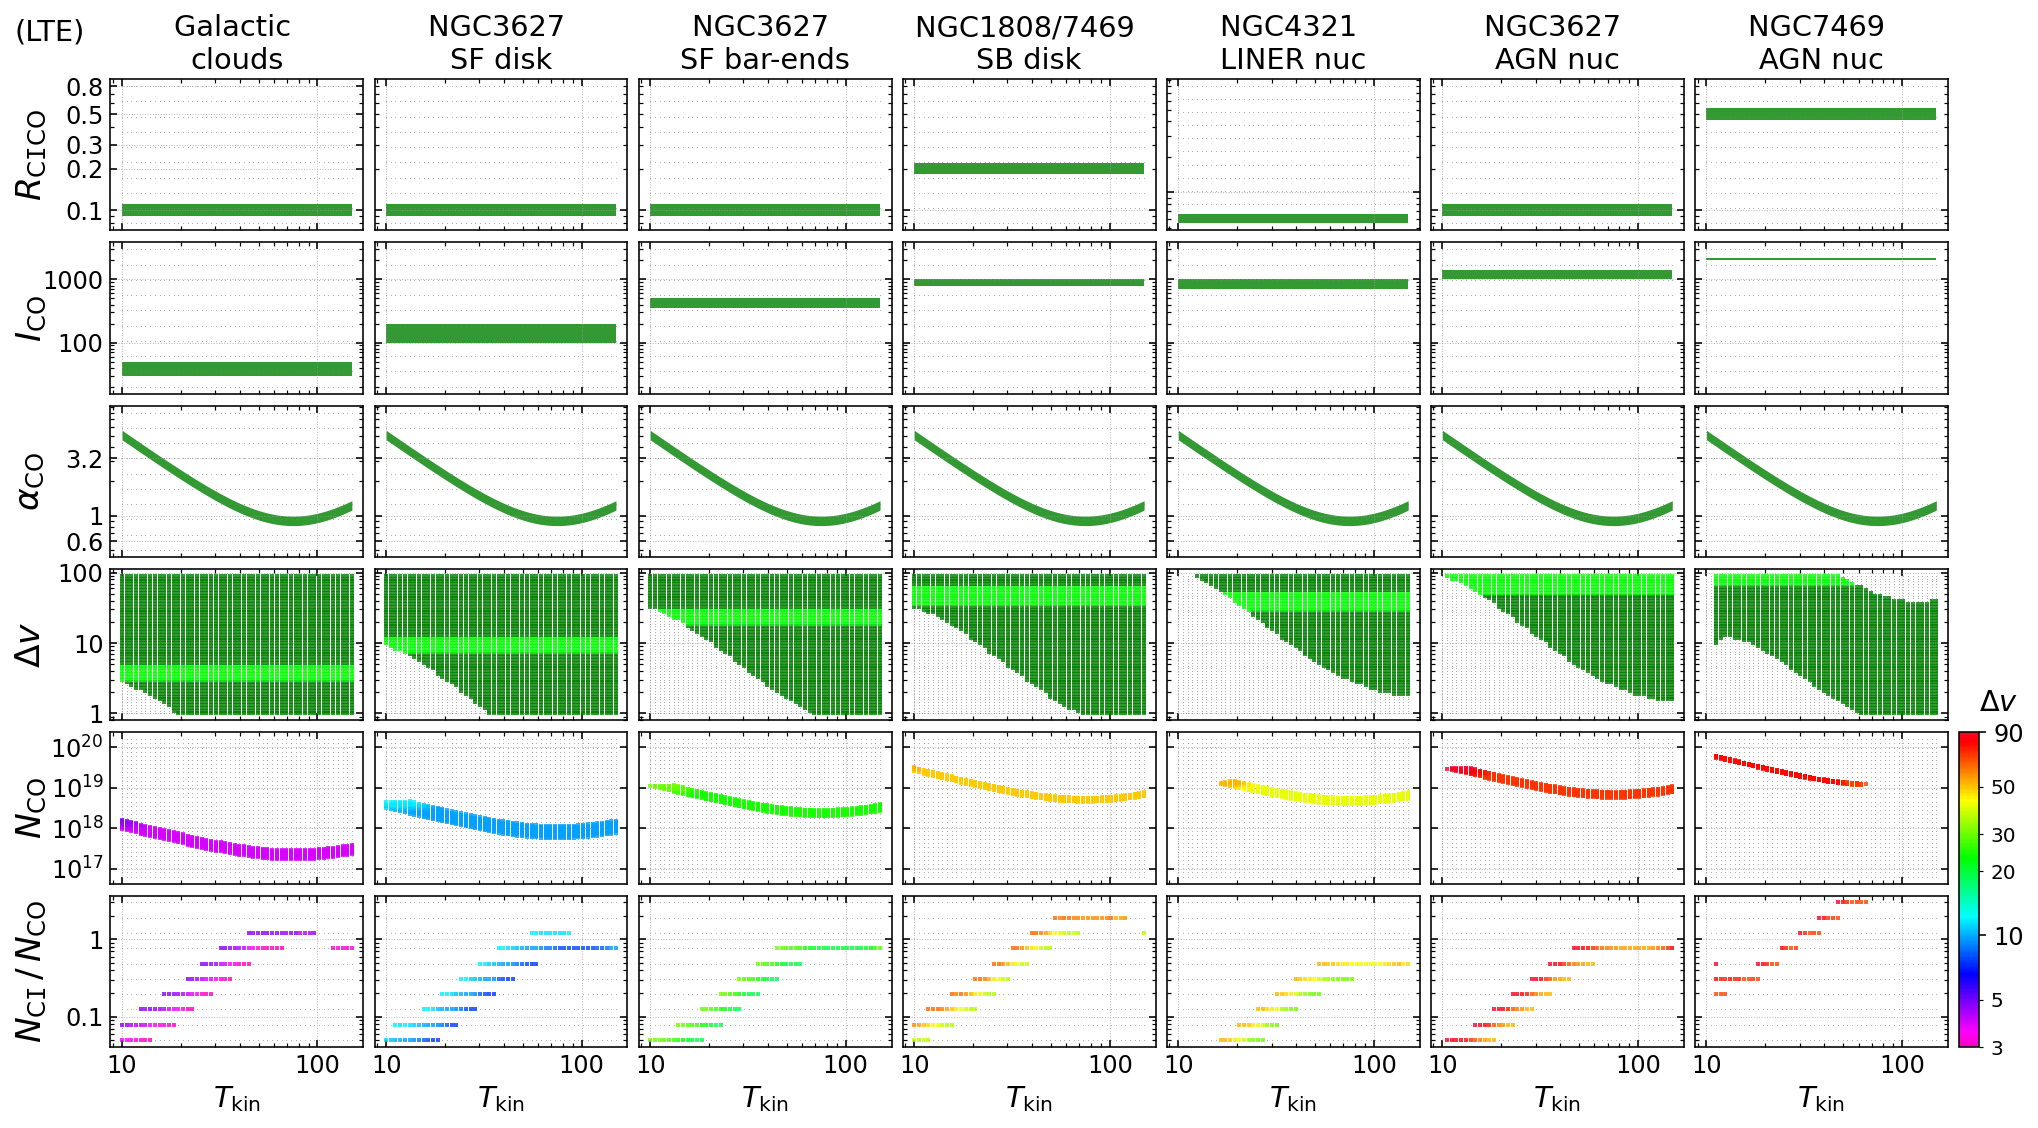

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
from matplotlib.patches import Rectangle

minima = np.nan
maxima = np.nan
fig = plt.figure(figsize=out_fig_size)
npanel = len(list_of_highlight_text_label_per_panel)
gs = gridspec.GridSpec(ncols=npanel+1, nrows=6, figure=fig, 
                       width_ratios=[1]*npanel+[0.08], wspace=0.05, hspace=0.08)
row_axes = OrderedDict()
row_axes['R_CICO'] = []
row_axes['I_CO'] = []
row_axes['alpha_CO'] = []
row_axes['d_V'] = []
row_axes['N_CO'] = []
row_axes['X_CICO'] = []
for irow, key in enumerate(row_axes.keys()):
    for icol in range(npanel):
        ax = fig.add_subplot(gs[irow, icol])
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
        ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', labelsize='large')
        ax.grid(True, c='#999999', lw=0.5, ls='dotted', alpha=0.7)
        row_axes[key].append(ax)

fig.subplots_adjust(**out_fig_margin)

#norm = matplotlib.colors.LogNorm(vmin=np.min(list_of_d_V), vmax=np.max(list_of_d_V), clip=True)
norm = matplotlib.colors.LogNorm(vmin=3.0, vmax=np.max(list_of_d_V), clip=True) # color by d_V
cmap = cm.gist_rainbow_r
colormapper = cm.ScalarMappable(norm=norm, cmap=cmap)


out_figure_file = 'Plot_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.pdf'

cache_3D_data_file = os.path.join(cache_table_path, 'out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.fits')
cache_5D_data_file = os.path.join(cache_table_path, 'out_LTE_contour_R_CI10CO21_x_T_kin_y_d_V.npy')
if not os.path.isdir(cache_table_path):
    os.makedirs(cache_table_path)

list_of_X_CICO = np.logspace(np.log10(0.05), np.log10(3.0), num=10, endpoint=True)
n_d_V = len(list_of_d_V)
n_T_kin = len(list_of_T_kin)
n_X_CICO = len(list_of_X_CICO)
n_N_CO = 10

if os.path.isfile(cache_3D_data_file) and use_cache_file:
    print(f'Loading file {cache_3D_data_file}')
    cache_3D_data_array = fits.getdata(cache_3D_data_file)
else:
    cache_3D_data_array = np.full((npanel, n_d_V, n_T_kin, ), fill_value=np.nan)

if os.path.isfile(cache_5D_data_file) and use_cache_file:
    print(f'Loading file {cache_5D_data_file}')
    cache_5D_data_array = np.load(cache_5D_data_file)
    print('cache_5D_data_array[0,0,0,0:1,:]', cache_5D_data_array[0,0,0,0:1,:])
else:
    cache_5D_data_array = np.full((npanel, n_d_V, n_T_kin, n_X_CICO, n_N_CO), fill_value=np.nan)

for ipanel in range(npanel):
    
    icol = ipanel
    
    # get per panel parameters
    CO_abundance = list_of_CO_abundance_per_panel[ipanel]
    
    # R_CICO panel (row 1)
    ax = row_axes['R_CICO'][icol]
    if icol == 0:
        ax.text(-0.38, 0.5, 
                #r'$R_{\mathrm{C}{\tt{I}}\mathrm{CO}} \, = $' + '\n' + \
                #r'$I_{\mathrm{C}{\tt{I}}(1-0)} \, / \, I_{\mathrm{CO}(2-1)}$', 
                r'$R_{\mathrm{C}{\tt{I}}\mathrm{CO}}$', 
                fontsize='xx-large', ha='left', va='center', rotation=90, transform=ax.transAxes)
        ax.set_yticks([0.1, 0.2, 0.3, 0.5, 0.8])
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
    ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide x ticks in the non-last-row panel
    
    # I_CO panel (row 2)
    ax = row_axes['I_CO'][icol]
    if icol == 0:
        ax.text(-0.38, 0.5, 
                r'$I_{\mathrm{CO}}$', 
                fontsize='xx-large', ha='left', va='center', rotation=90, transform=ax.transAxes)
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
    ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide x ticks in the non-last-row panel
    
    # alpha_CO panel (row 3)
    ax = row_axes['alpha_CO'][icol]
    if icol == 0:
        ax.text(-0.38, 0.5, 
                r'$\alpha_{\mathrm{CO}}$', 
                fontsize='xx-large', ha='left', va='center', rotation=90, transform=ax.transAxes)
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
    ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide x ticks in the non-last-row panel
    
    # N_CO panel (row 5)
    ax = row_axes['N_CO'][icol]
    if icol == 0:
        ax.text(-0.38, 0.5, 
                #r'$N_{\mathrm{CO}} \, = \, I_{\mathrm{CO}} \cdot $' + '\n' + \
                #r'$\alpha_{\mathrm{CO}}^{-1} \, \cdot \, X_{\mathrm{[CO/H_2]}}$', 
                r'$N_{\mathrm{CO}}$', 
                fontsize='xx-large', ha='left', va='center', rotation=90, transform=ax.transAxes)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda x, pos: "$10^{%.0f}$"%(np.log10(x)))) # N_CO y tick label str format
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y tick labels in the non-first-column panel
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15)) # show y tick lines in log10
    ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide x ticks in the non-last-row panel
    
    # d_V panel (row 4)
    ax = row_axes['d_V'][icol]
    if icol == 0:
        ax.text(-0.38, 0.5, 
                r'$\Delta v$', 
                fontsize='xx-large', ha='left', va='center', rotation=90, transform=ax.transAxes)
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
    ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide x ticks in the non-last-row panel
    
    # X_CICO panel (row 6)
    ax = row_axes['X_CICO'][icol]
    if icol == 0:
        ax.text(-0.38, 0.5, 
                r'$N_{\mathrm{C{\tt{I}}}} \, / \, N_{\mathrm{CO}}$', 
                fontsize='xx-large', ha='left', va='center', rotation=90, transform=ax.transAxes)
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter()) # hide y ticks in the non-first-column panel
    #ax.xaxis.set_major_formatter(ticker.NullFormatter()) # hide x ticks in the non-last-row panel
    
    # clear ax variable 
    ax = None
    
    
    # top text label in the first row panels
    highlight_text_label = list_of_highlight_text_label_per_panel[ipanel]
    ax = row_axes[list(row_axes.keys())[0]][icol]
    ax.text(
        0.5, 1.03, highlight_text_label, ha='center', va='bottom', fontsize='x-large', 
        transform=ax.transAxes, zorder=99)
    if icol == 0:
        ax.text(-0.38, 1.22, '(LTE)', ha='left', va='bottom', fontsize='x-large', transform=ax.transAxes)
    ax = None
    
    # x axis title in the last row panels
    ax = row_axes[list(row_axes.keys())[-1]][icol]
    ax.set_xlabel(r'$T_{\mathrm{kin}}$', fontsize='x-large', labelpad=3)
    ax = None
    
    
    # get CO flux range (hence H2 surface density) and R_{CI10/CO21} line ratio range for each panel
    highlight_Flux_Kkms_CO10_range = list_of_highlight_Flux_Kkms_CO10_range_per_panel[ipanel]
    highlight_R_CI10CO21 = list_of_highlight_R_CI10CO21_per_panel[ipanel]
    
    # draw a dot at each cell in d_V panel
    xgrid, ygrid = np.meshgrid(list_of_T_kin, list_of_d_V)
    row_axes['d_V'][icol].plot(xgrid, ygrid, ls='none', lw=0, 
                               markersize=1, marker='.', mew=0, color='gray', alpha=0.8)
    
    # draw a dot at each cell in X_CICO panel
    xgrid2, ygrid2 = np.meshgrid(list_of_T_kin, list_of_X_CICO)
    row_axes['X_CICO'][icol].plot(xgrid2, ygrid2, ls='none', lw=0, 
                                  markersize=1, marker='.', mew=0, color='gray', alpha=0.8)
    
    # draw a dot at each cell in row3 panel
    list_of_N_CO_overall = np.logspace(16.80, 20.20, # 18.25, 20.25, 
                                       num=int((20.20-16.80)/0.1)+1, # num=n_N_CO, 
                                       endpoint=True) #<TODO># tune this
    xgrid3, ygrid3 = np.meshgrid(list_of_T_kin, list_of_N_CO_overall)
    row_axes['N_CO'][icol].plot(xgrid3, ygrid3, ls='none', lw=0, 
                                markersize=1, marker='.', mew=0, color='gray', alpha=0.8)
    
    # draw a line in row4 panel
    list_of_Flux_Kkms_CO10_overall = np.logspace(np.log10(20), np.log10(3000), 
                                                 num=10, endpoint=True) #<TODO># tune this
    xgrid4, ygrid4 = np.meshgrid(list_of_T_kin, list_of_Flux_Kkms_CO10_overall)
    row_axes['I_CO'][icol].plot(xgrid4, ygrid4, ls='none', lw=0, 
                                markersize=1, marker='.', mew=0, color='gray', alpha=0.8)
    row_axes['I_CO'][icol].fill_between(list_of_T_kin, 
                                        [highlight_Flux_Kkms_CO10_range[0]]*len(list_of_T_kin), 
                                        [highlight_Flux_Kkms_CO10_range[1]]*len(list_of_T_kin), 
                                        lw=0, color='green', alpha=0.8)
    
    # draw a line in row5 panel
    list_of_alpha_CO_overall = np.logspace(np.log10(0.5), np.log10(8.0), 
                                           num=10, endpoint=True) #<TODO># tune this
    xgrid5, ygrid5 = np.meshgrid(list_of_T_kin, list_of_alpha_CO_overall)
    row_axes['alpha_CO'][icol].plot(xgrid5, ygrid5, ls='none', lw=0, 
                                    markersize=1, marker='.', mew=0, color='gray', alpha=0.8)
    row_axes['alpha_CO'][icol].fill_between(list_of_T_kin, 
                                            [func_alphaCO(t, CO_abundance) / 1.1 for t in list_of_T_kin], 
                                            [func_alphaCO(t, CO_abundance) * 1.1 for t in list_of_T_kin], 
                                            lw=0, color='green', alpha=0.8) # showing +-10% range
    row_axes['alpha_CO'][icol].set_yticks([0.6, 1.0, 3.2])
    
    # draw a line in row6 panel
    list_of_R_CICO_overall = np.logspace(np.log10(0.08), np.log10(0.8), 
                                         num=10, endpoint=True) #<TODO># tune this
    xgrid6, ygrid6 = np.meshgrid(list_of_T_kin, list_of_R_CICO_overall)
    row_axes['R_CICO'][icol].plot(xgrid6, ygrid6, ls='none', lw=0, 
                                  markersize=1, marker='.', mew=0, color='gray', alpha=0.8)
    row_axes['R_CICO'][icol].fill_between(list_of_T_kin, 
                                          [highlight_R_CI10CO21/1.1]*len(list_of_T_kin), 
                                          [highlight_R_CI10CO21*1.1]*len(list_of_T_kin), 
                                          lw=0, color='green', alpha=0.8)
    
    # loop grid of T kin (x) and Delta v (y)
    for i_T_kin, T_kin in enumerate(list_of_T_kin):
        # 
        # compute N_CO range for this T_kin from I_CO or Sigma_H2 range
        highlight_Sigma_H2_range = list_of_highlight_Sigma_H2_range_per_panel[ipanel]
        highlight_alphaCO = func_alphaCO(T_kin, CO_abundance)
        if highlight_Sigma_H2_range is None:
            highlight_Sigma_H2_range = (\
                highlight_Flux_Kkms_CO10_range[0] * highlight_alphaCO, 
                # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
                highlight_Flux_Kkms_CO10_range[1] * highlight_alphaCO, 
                # convert CO flux in units of K km s-1 to H2 surface density in M_sun pc^-2, no helium.
            )
        highlight_N_CO_range = np.array(highlight_Sigma_H2_range) * \
                               CO_abundance / 1.60141791e-20 # in units of cm^-2
        print('ipanel {} T_kin {:.2f} alphaCO {:.2f} I_CO {:.3g} {:.3g}'.format(
                 ipanel, T_kin, highlight_alphaCO, 
                 highlight_Flux_Kkms_CO10_range[0], highlight_Flux_Kkms_CO10_range[1], 
               ) + 
              ' N_CO {:.2e} {:.2e} Sigma_H2 {:.2e} {:.2e}'.format(
                 highlight_N_CO_range[0], highlight_N_CO_range[1],
                 highlight_Sigma_H2_range[0], highlight_Sigma_H2_range[1],
               )
             )
        # 
        list_of_N_CO = np.logspace(np.log10(highlight_N_CO_range[0]), 
                                   np.log10(highlight_N_CO_range[1]), 
                                   num=n_N_CO, endpoint=True)
        # 
        did_calculation = False
        # 
        for i_d_V, d_V in enumerate(list_of_d_V):
            # 
            # each cell has a range of N_CO and N_CO*X_CICO, we need to 
            # compute R_CI10CO21 for each 5D parameter set. 
            for i_X_CICO, X_CICO in enumerate(list_of_X_CICO):
                for i_N_CO, N_CO in enumerate(list_of_N_CO):
                    # use cache data array
                    if np.isnan(cache_5D_data_array[ipanel, i_d_V, i_T_kin, i_X_CICO, i_N_CO]):
                        R_CI10CO21 = calc_one_LTE_R_CI10CO21(
                            N_CO = N_CO, 
                            d_V = d_V, 
                            T_kin = T_kin, 
                            X_CICO = X_CICO, 
                            verbose = False,
                        )
                        cache_5D_data_array[ipanel, i_d_V, i_T_kin, i_X_CICO, i_N_CO] = R_CI10CO21
                        did_calculation = True
                        #20220109 hide some printing
                        #print('(panel, i_d_V, i_T_kin, i_X_CICO, i_N_CO): '
                        #      '(%d/%d, %d/%d, %d/%d, %d/%d, %d/%d)'%(
                        #    ipanel+1, npanel, i_T_kin+1, len(list_of_T_kin), i_d_V+1, n_d_V, 
                        #    i_X_CICO+1, n_X_CICO, i_N_CO+1, n_N_CO, 
                        #))
                    else:
                        R_CI10CO21 = cache_5D_data_array[ipanel, i_d_V, i_T_kin, i_X_CICO, i_N_CO]
            # 
            # print
            #print('(panel, x, y): (%d/%d, %d/%d, %d/%d)'%(
            #      ipanel+1, npanel, i_T_kin+1, len(list_of_T_kin), i_d_V+1, len(list_of_d_V)))
        # 
        # check whether the observed R_CI10CO21 can be reproduced in each cell of ax
        for i_d_V, d_V in enumerate(list_of_d_V):
            subarray_by_T_kin_d_V = cache_5D_data_array[ipanel, 
                                                        i_d_V, i_T_kin, :, :] # subarray [i_X_CICO, i_N_CO]
            result_min_R_CI10CO21 = np.min(subarray_by_T_kin_d_V)
            result_max_R_CI10CO21 = np.max(subarray_by_T_kin_d_V)
            this_cell_can_reproduce_obs = (result_min_R_CI10CO21 <= highlight_R_CI10CO21 and 
                                           result_max_R_CI10CO21 >= highlight_R_CI10CO21)
            # 
            # draw a big dot
            if this_cell_can_reproduce_obs:
                if np.isclose(d_V, list_of_d_V_limit_per_panel[ipanel], rtol=0.3, atol=0.0):
                    row_axes['d_V'][icol].plot([T_kin], [d_V], 
                                               markersize=2, marker='s', lw=0, mew=0, color='lime', alpha=0.8)
                else:
                    row_axes['d_V'][icol].plot([T_kin], [d_V], 
                                               markersize=2, marker='s', lw=0, mew=0, color='green', alpha=0.8)
                cache_3D_data_array[ipanel, i_d_V, i_T_kin] = 1
            else:
                cache_3D_data_array[ipanel, i_d_V, i_T_kin] = 0
        # 
        # check whether the observed R_CI10CO21 can be reproduced in each cell of ax2
        for i_X_CICO, X_CICO in enumerate(list_of_X_CICO):
            subarray_by_T_kin_X_CICO = cache_5D_data_array[ipanel, 
                                                           :, i_T_kin, i_X_CICO, :] # subarray [i_d_V, i_N_CO]
            result_min_R_CI10CO21 = np.min(subarray_by_T_kin_X_CICO)
            result_max_R_CI10CO21 = np.max(subarray_by_T_kin_X_CICO)
            this_cell_can_reproduce_obs = (result_min_R_CI10CO21 <= highlight_R_CI10CO21 and 
                                           result_max_R_CI10CO21 >= highlight_R_CI10CO21)
            #print('subarray_by_T_kin_X_CICO', subarray_by_T_kin_X_CICO)
            #print('highlight_R_CI10CO21', highlight_R_CI10CO21)
            # 
            # draw a big dot
            if this_cell_can_reproduce_obs:
                # color by d_V
                acceptable_d_V = []
                for i_d_V, d_V in enumerate(list_of_d_V):
                    if np.isclose(d_V, list_of_d_V_limit_per_panel[ipanel], rtol=0.3, atol=0.0) and \
                       np.min(subarray_by_T_kin_X_CICO[i_d_V, :]) <= highlight_R_CI10CO21 and \
                       np.max(subarray_by_T_kin_X_CICO[i_d_V, :]) >= highlight_R_CI10CO21:
                        acceptable_d_V.append(d_V)
                if len(acceptable_d_V) == 0:
                    # recompute with a looser condition
                    for i_d_V, d_V in enumerate(list_of_d_V):
                        if np.isclose(d_V, list_of_d_V_limit_per_panel[ipanel], rtol=0.3, atol=0.0) and \
                           np.min(subarray_by_T_kin_X_CICO[i_d_V, :]) <= highlight_R_CI10CO21*1.1 and \
                           np.max(subarray_by_T_kin_X_CICO[i_d_V, :]) >= highlight_R_CI10CO21/1.1:
                            acceptable_d_V.append(d_V)
                #if len(acceptable_d_V) == 0:
                #    print('subarray_by_T_kin_X_CICO', subarray_by_T_kin_X_CICO)
                #    print('highlight_R_CI10CO21', highlight_R_CI10CO21)
                if len(acceptable_d_V) > 0:
                    d_V_min = np.min(acceptable_d_V)
                    d_V_max = np.max(acceptable_d_V)
                    d_V_mean = (d_V_min + d_V_max) / 2.0
                    # 
                    row_axes['X_CICO'][icol].plot([T_kin], [X_CICO], 
                                                  markersize=2, marker='s', lw=0, mew=0, 
                                                  color=colormapper.to_rgba(d_V_mean), alpha=0.8)
        # 
        # check whether the observed R_CI10CO21 can be reproduced in each cell of ax3
        for i_N_CO, N_CO in enumerate(list_of_N_CO):
            subarray_by_T_kin_N_CO = cache_5D_data_array[ipanel, 
                                                         :, i_T_kin, :, i_N_CO] # subarray [i_d_V, i_X_CICO]
            result_min_R_CI10CO21 = np.min(subarray_by_T_kin_N_CO)
            result_max_R_CI10CO21 = np.max(subarray_by_T_kin_N_CO)
            this_cell_can_reproduce_obs = (result_min_R_CI10CO21 <= highlight_R_CI10CO21 and 
                                           result_max_R_CI10CO21 >= highlight_R_CI10CO21)
            # 
            # draw a big dot
            if this_cell_can_reproduce_obs:
                # color by d_V
                acceptable_d_V = []
                for i_d_V, d_V in enumerate(list_of_d_V):
                    if np.isclose(d_V, list_of_d_V_limit_per_panel[ipanel], rtol=0.3, atol=0.0) and \
                       np.min(subarray_by_T_kin_N_CO[i_d_V, :]) <= highlight_R_CI10CO21 and \
                       np.max(subarray_by_T_kin_N_CO[i_d_V, :]) >= highlight_R_CI10CO21:
                        acceptable_d_V.append(d_V)
                if len(acceptable_d_V) == 0:
                    # recompute with a looser condition
                    for i_d_V, d_V in enumerate(list_of_d_V):
                        if np.isclose(d_V, list_of_d_V_limit_per_panel[ipanel], rtol=0.3, atol=0.0) and \
                           np.min(subarray_by_T_kin_N_CO[i_d_V, :]) <= highlight_R_CI10CO21*1.1 and \
                           np.max(subarray_by_T_kin_N_CO[i_d_V, :]) >= highlight_R_CI10CO21/1.1:
                            acceptable_d_V.append(d_V)
                #if len(acceptable_d_V) == 0:
                #    print('subarray_by_T_kin_X_CICO', subarray_by_T_kin_X_CICO)
                #    print('highlight_R_CI10CO21', highlight_R_CI10CO21)
                if len(acceptable_d_V) > 0:
                    d_V_min = np.min(acceptable_d_V)
                    d_V_max = np.max(acceptable_d_V)
                    d_V_mean = (d_V_min + d_V_max) / 2.0
                    # 
                    #print('ax3.plot', '[T_kin]', T_kin, '[N_CO]', N_CO)
                    row_axes['N_CO'][icol].plot([T_kin], [N_CO], 
                                                markersize=2, marker='s', lw=0, mew=0, 
                                                color=colormapper.to_rgba(d_V_mean), alpha=0.8)
        
        # 
        #fig.canvas.draw()
        #fig.canvas.flush_events()
        
        # save cache when finishing every 5 row of each panel
        if did_calculation and (
                (i_T_kin > 0 and i_T_kin % (len(list_of_T_kin)//5) == 0) or (i_T_kin == len(list_of_T_kin)-1)
            ):
            # 
            if os.path.isfile(cache_3D_data_file):
                shutil.move(cache_3D_data_file, cache_3D_data_file+'.backup')
            hdu = fits.PrimaryHDU(data=cache_3D_data_array)
            hdu.writeto(cache_3D_data_file)
            print(f'Output to "{cache_3D_data_file}"')
            # 
            if os.path.isfile(cache_5D_data_file):
                shutil.move(cache_5D_data_file, cache_5D_data_file+'.backup')
            np.save(cache_5D_data_file, cache_5D_data_array)
            print(f'Output to "{cache_5D_data_file}"')

# print axis lim
# for ipanel in range(npanel):
#     print("row_axes['N_CO'][ipanel].get_ylim()", row_axes['N_CO'][ipanel].get_ylim())
#     if ipanel == 0:
#         ax = row_axes['N_CO'][ipanel]
#         ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
            
# add color bar
colorbar_title = r'$\Delta v$'
colorbar_ticks = list_of_N_CO
ax_colorbar = fig.add_subplot(gs[-2:, -1]) # last two rows, last column
#ax_colorbar.set_title(colorbar_title, fontsize='x-large', pad=10, loc='left')
ax_colorbar.text(0.98, 1.05, colorbar_title, 
                 fontsize='x-large', ha='left', va='bottom', transform=ax_colorbar.transAxes)
ax_colorbar.tick_params(labelsize='large')
cbar = fig.colorbar(mappable=colormapper, cax=ax_colorbar)
cbar.set_ticks([1., 10., 90.])
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
cbar.ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%g'))
cbar.ax.yaxis.set_minor_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.5, )))

fig.savefig(out_figure_file, dpi=300)
print(f'Output to "{out_figure_file}"')


## 